In [1]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

ref: https://pyro.ai/examples/intro_long.html

In [2]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.1')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [3]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]

In [4]:
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [5]:
df

,cont_africa,rugged,rgdppc_2000
2,1,0.858,7.492609
4,0,3.427,8.216929
7,0,0.769,9.933263
8,0,0.775,9.407032
9,0,2.688,7.792343
...,...,...,...
229,0,1.677,8.488849
230,0,2.323,6.669180
231,1,1.761,9.150497
232,1,0.533,6.651585


In [6]:
# convert numpy array to a torch.Tensor for Pyro to analyze
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

In [7]:
is_cont_africa

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1.,
        1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
        1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1.])

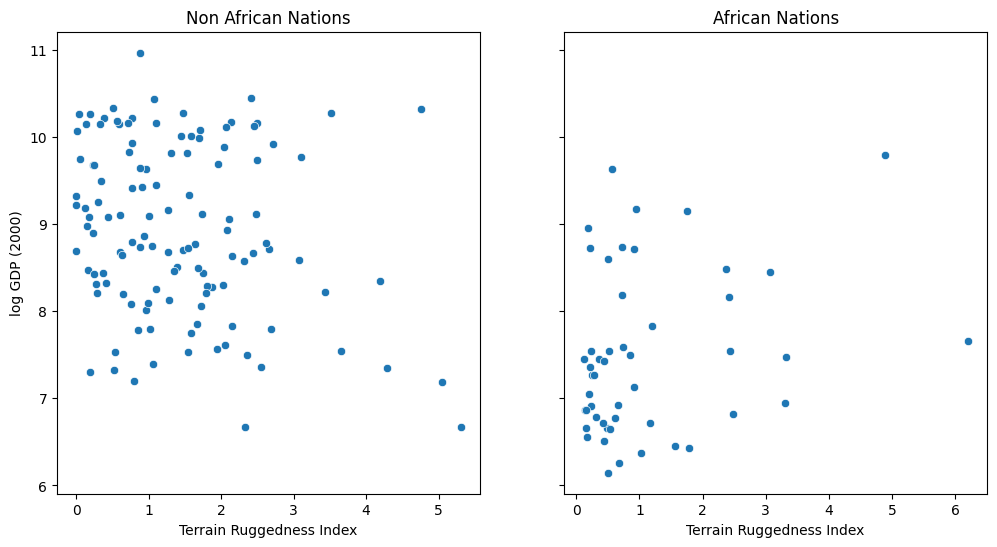

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

# models in Pyro

mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

In [9]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def simple_model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.param("a", lambda: torch.randn(()))
    b_a = pyro.param("bA", lambda: torch.randn(()))
    b_r = pyro.param("bR", lambda: torch.randn(()))
    b_ar = pyro.param("bAR", lambda: torch.randn(()))
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)



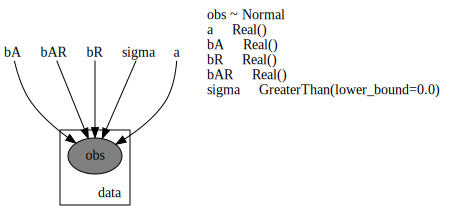

In [10]:
pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True, render_params=True)

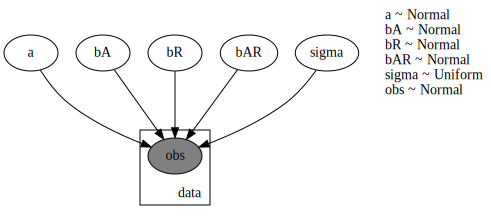

In [11]:
def model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True)

# variational inference

In [13]:
# variational distribution used to approximate the true posterior is called the guide in Pyro
# guide has to match with the sample statement

# example: mean-field variational approximation for Bayesian linear regression

# we will use a guide that models the distribution of unobserved parameters in the model as a Gaussian with diagonal covariance, 
# i.e. it assumes that there is no correlation amongst the latent variables (quite a strong assumption as we shall see). 
# This is known as a mean-field approximation

def custom_guide(is_cont_africa, ruggedness, log_gdp=None):
    a_loc = pyro.param('a_loc', lambda: torch.tensor(0.))
    a_scale = pyro.param('a_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', lambda: torch.randn(3))
    weights_scale = pyro.param('weights_scale', lambda: torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    return {"a": a, "b_a": b_a, "b_r": b_r, "b_ar": b_ar, "sigma": sigma}



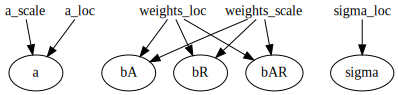

In [14]:
pyro.render_model(custom_guide, model_args=(is_cont_africa, ruggedness, log_gdp), render_params=True)

In [15]:
# automatically generate guide program:

auto_guide = pyro.infer.autoguide.AutoNormal(model)


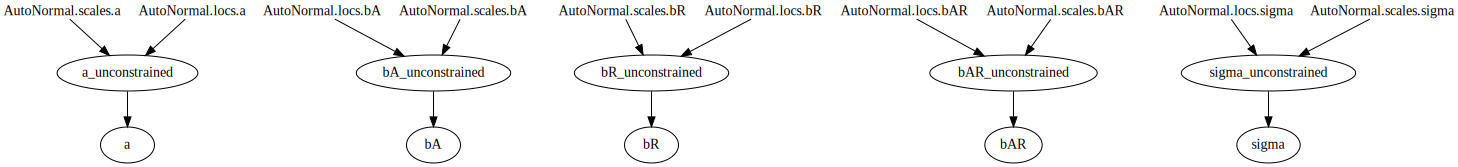

In [16]:
pyro.render_model(auto_guide, model_args=(is_cont_africa, ruggedness, log_gdp), render_params=True)

# optimizing ELBO

In [17]:
# stochastic variational inference
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

Elbo loss: 694.9404839277267
Elbo loss: 524.3822104930878
Elbo loss: 475.66814601421356
Elbo loss: 399.9908838868141
Elbo loss: 315.2327741384506
Elbo loss: 254.76770013570786
Elbo loss: 248.2370102405548
Elbo loss: 248.42670458555222
Elbo loss: 248.4645066857338
Elbo loss: 257.4146338701248


Wall time: 5.38 s


Text(0, 0.5, 'ELBO loss')

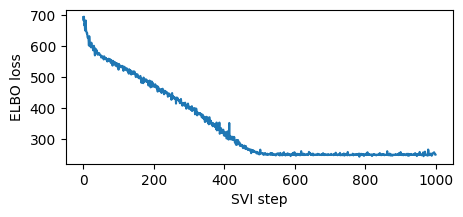

In [20]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [21]:
# the result of trained guide: approximate distribution
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.a 9.173145
AutoNormal.scales.a 0.07036689
AutoNormal.locs.bA -1.847466
AutoNormal.scales.bA 0.14070092
AutoNormal.locs.bR -0.19032118
AutoNormal.scales.bR 0.044044234
AutoNormal.locs.bAR 0.35599765
AutoNormal.scales.bAR 0.07937439
AutoNormal.locs.sigma -2.205863
AutoNormal.scales.sigma 0.060526706


In [22]:
# revisit our earlier question of how robust the relationship between terrain ruggedness 
# and GDP is against any uncertainty in the parameter estimates from our model. 
# For this, we plot the distribution of the slope of the log GDP given terrain ruggedness for nations within and outside Africa.

# We represent these two distributions with samples drawn from our trained guide. 
# To draw multiple samples in parallel, we can call the guide within a pyro.plate statement 
# which repeats and vectorizes the sampling operations for each pyro.sample statement in the guide, 
# as described in the section introducing the pyro.plate primitive.

with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(is_cont_africa, ruggedness)

gamma_within_africa = samples["bR"] + samples["bAR"]
gamma_outside_africa = samples["bR"]



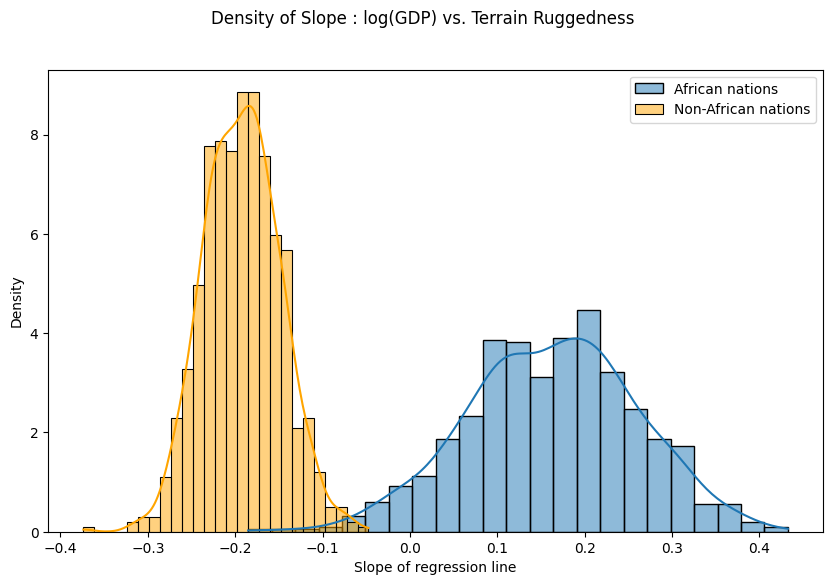

In [23]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(gamma_within_africa.detach().cpu().numpy(), kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), kde=True, stat="density", label="Non-African nations", color="orange")
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()

# posterior predictive distribution

In [24]:
predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=800)
svi_samples = predictive(is_cont_africa, ruggedness, log_gdp=None)
svi_gdp = svi_samples["obs"]

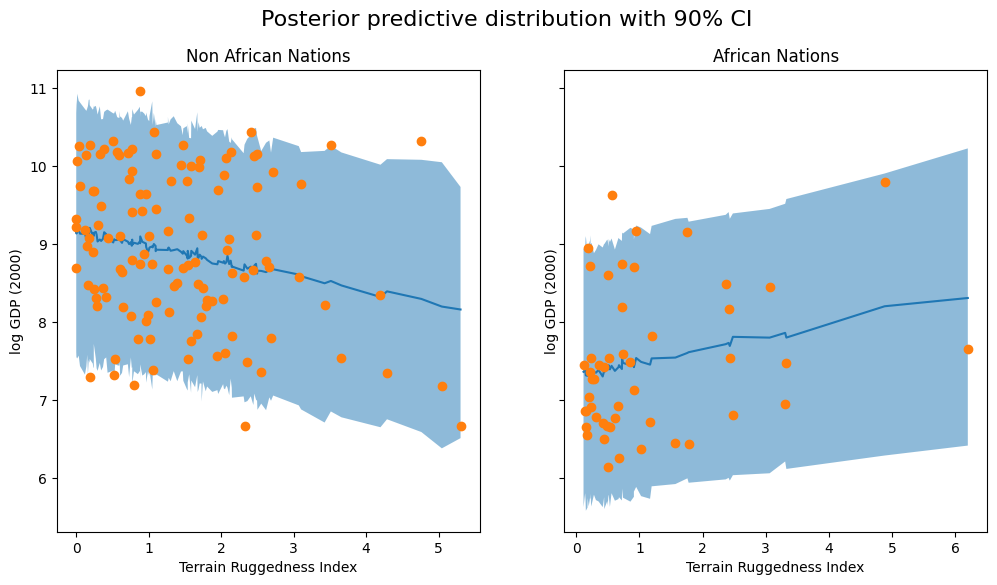

In [25]:
predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": svi_gdp.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_gdp.kthvalue(int(len(svi_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_gdp.kthvalue(int(len(svi_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})
african_nations = predictions[predictions["cont_africa"] == 1].sort_values(by=["rugged"])
non_african_nations = predictions[predictions["cont_africa"] == 0].sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["y_perc_5"], non_african_nations["y_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations")

ax[1].plot(african_nations["rugged"], african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"], african_nations["y_perc_5"], african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(african_nations["rugged"], african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations");

# model the covariance between parameters

In [26]:
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)

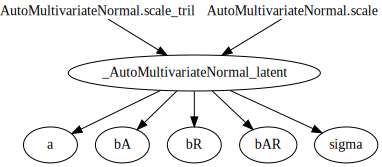

In [27]:
pyro.render_model(mvn_guide, model_args=(is_cont_africa, ruggedness, log_gdp), render_params=True)

Elbo loss: 702.49064463377
Elbo loss: 548.75765812397
Elbo loss: 490.9642730951309
Elbo loss: 401.8139214515686
Elbo loss: 333.7780352830887
Elbo loss: 247.01823371648788
Elbo loss: 248.3894458413124
Elbo loss: 247.35121178627014
Elbo loss: 248.2095891237259
Elbo loss: 247.2100682258606


Wall time: 4.78 s


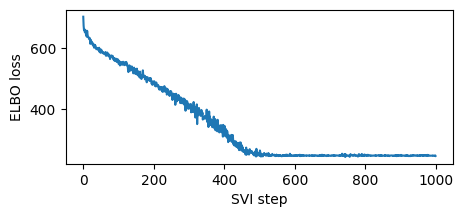

In [28]:
%%time
pyro.clear_param_store()
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
svi = pyro.infer.SVI(model,
                     mvn_guide,
                     pyro.optim.Adam({"lr": 0.02}),
                     pyro.infer.Trace_ELBO())

losses = []
for step in range(1000 if not smoke_test else 2):
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

with pyro.plate("samples", 800, dim=-1):
    mvn_samples = mvn_guide(is_cont_africa, ruggedness)

mvn_gamma_within_africa = mvn_samples["bR"] + mvn_samples["bAR"]
mvn_gamma_outside_africa = mvn_samples["bR"]

# Interface note: reuse guide samples for prediction by passing them to Predictive
# via the posterior_samples keyword argument instead of passing the guide as above
assert "obs" not in mvn_samples
mvn_predictive = pyro.infer.Predictive(model, posterior_samples=mvn_samples)
mvn_predictive_samples = mvn_predictive(is_cont_africa, ruggedness, log_gdp=None)

mvn_gdp = mvn_predictive_samples["obs"]

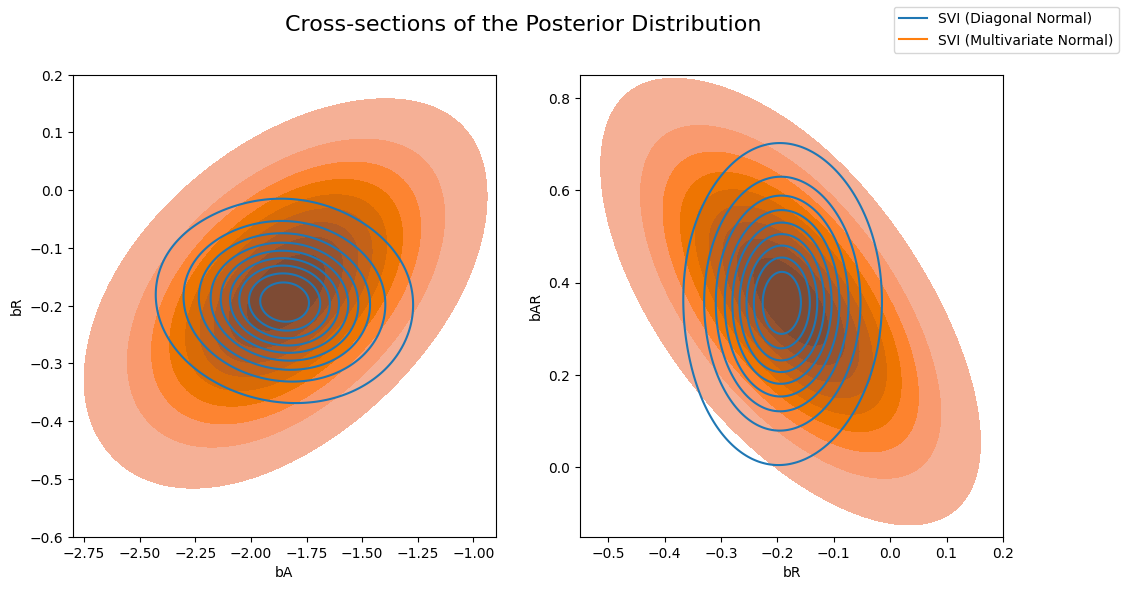

In [29]:
svi_samples = {k: v.detach().cpu().numpy() for k, v in samples.items()}
svi_mvn_samples = {k: v.detach().cpu().numpy() for k, v in mvn_samples.items()}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(svi_samples["bA"], y=svi_samples["bR"], ax=axs[0], bw_adjust=4 )
sns.kdeplot(svi_mvn_samples["bA"], y=svi_mvn_samples["bR"], ax=axs[0], shade=True, bw_adjust=4)
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.8, -0.9), ylim=(-0.6, 0.2))

sns.kdeplot(svi_samples["bR"], y=svi_samples["bAR"], ax=axs[1],bw_adjust=4 )
sns.kdeplot(svi_mvn_samples["bR"], y=svi_mvn_samples["bAR"], ax=axs[1], shade=True, bw_adjust=4)
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.55, 0.2), ylim=(-0.15, 0.85))


for label, color in zip(["SVI (Diagonal Normal)", "SVI (Multivariate Normal)"], sns.color_palette()[:2]):
    plt.plot([], [],
                label=label, color=color)

fig.legend(loc='upper right')

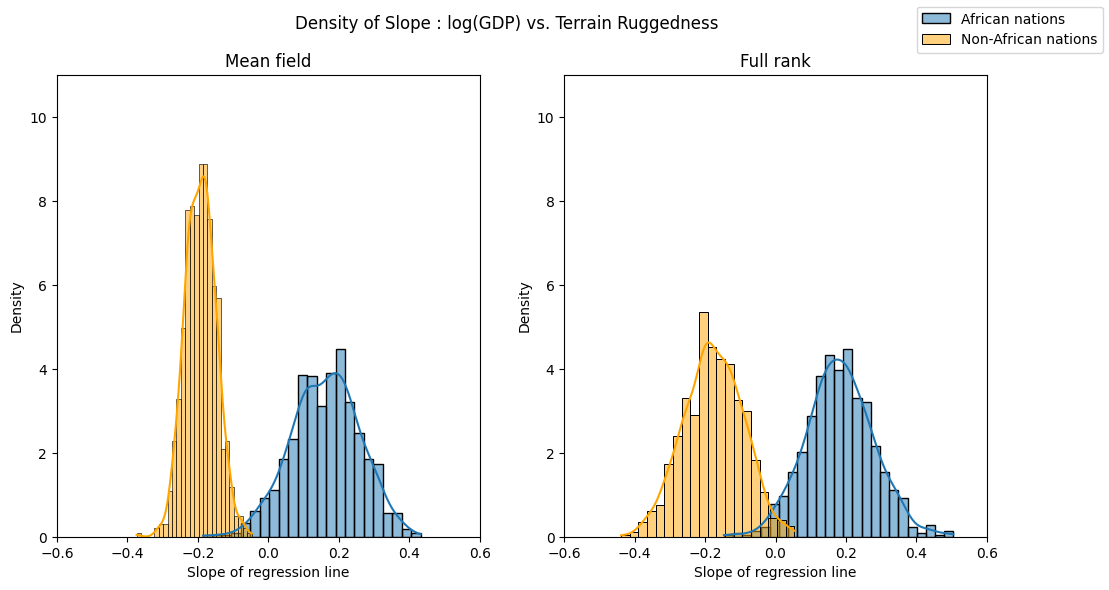

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

sns.histplot(gamma_within_africa.detach().cpu().numpy(), ax=axs[0], kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), ax=axs[0], kde=True, stat="density", color="orange", label="Non-African nations")
axs[0].set(title="Mean field", xlabel="Slope of regression line", xlim=(-0.6, 0.6), ylim=(0, 11))

sns.histplot(mvn_gamma_within_africa.detach().cpu().numpy(), ax=axs[1], kde=True, stat="density", label="African nations")
sns.histplot(mvn_gamma_outside_africa.detach().cpu().numpy(), ax=axs[1], kde=True, stat="density", color="orange", label="Non-African nations")
axs[1].set(title="Full rank", xlabel="Slope of regression line", xlim=(-0.6, 0.6), ylim=(0, 11))

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');